In [33]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from sklearn.preprocessing import StandardScaler

In [34]:
tpath = r'C:\Users\Gautam\Documents\GitHub\Predictive-Maintenance\cool_tests'
path = r'C:\Users\Gautam\Documents\GitHub\Predictive-Maintenance\Final_cooling_sys_data'

Reading the synthetic data

In [35]:
def moving_avg(x, N=1000):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

In [36]:
dsets = []
coollevel = []
fanspeed = []
cooltemp = []
for i in range(31):
    dsets.append(pd.read_csv(path + '\\final_cooling_dset_' + str(i)+'.csv'))
    dsets[i]['65263-111'] = dsets[i]['65263-111'].mode()[0].astype(int)         #replacing synthetic float coolant levels with int modes to remove noise
    coollevel.append(dsets[i]['65263-111'][::10])

    dsets[i].loc[dsets[i]['64817-1598'] != 0, '64817-1598'] = 4096.
    fanspeed.append(dsets[i]['64817-1598'][::10])
    fanspeed[i] = fanspeed[i].astype(int)

    vals = moving_avg(dsets[i]['65262-110'])
    cooltemp.append(vals[::250])

for i in range(8):
    dsets.append(pd.read_csv(path + '\\faulty_cooling_dset_' + str(i)+'.csv'))
    dsets[31+i]['65263-111'] = dsets[31+i]['65263-111'].astype(int)
    
    coollevel.append(dsets[31+i]['65263-111'][::10])

    fanspeed.append(dsets[31+i]['64817-1598'][::10])
    fanspeed[31+i] = fanspeed[31+i].astype(int)

    vals = moving_avg(dsets[31+i]['65262-110'])
    cooltemp.append(vals[::250])


Creating a formatted time series sets for each component

In [37]:
formatted_level = to_time_series_dataset(coollevel)
formatted_speed = to_time_series_dataset(fanspeed)
formatted_temp = to_time_series_dataset(cooltemp)
print("Coolant Level Shape: " + str(formatted_level.shape))
print("Fan Speed Shape: " + str(formatted_speed.shape))
print("Coolant Temperature Shape: " + str(formatted_temp.shape))

Coolant Level Shape: (39, 9255, 1)
Fan Speed Shape: (39, 9255, 1)
Coolant Temperature Shape: (39, 367, 1)


In [38]:
#Scaling
formatted_level = TimeSeriesScalerMeanVariance().fit_transform(formatted_level)
#formatted_speed = TimeSeriesScalerMinMax(value_range=(0,100)).fit_transform(formatted_speed)

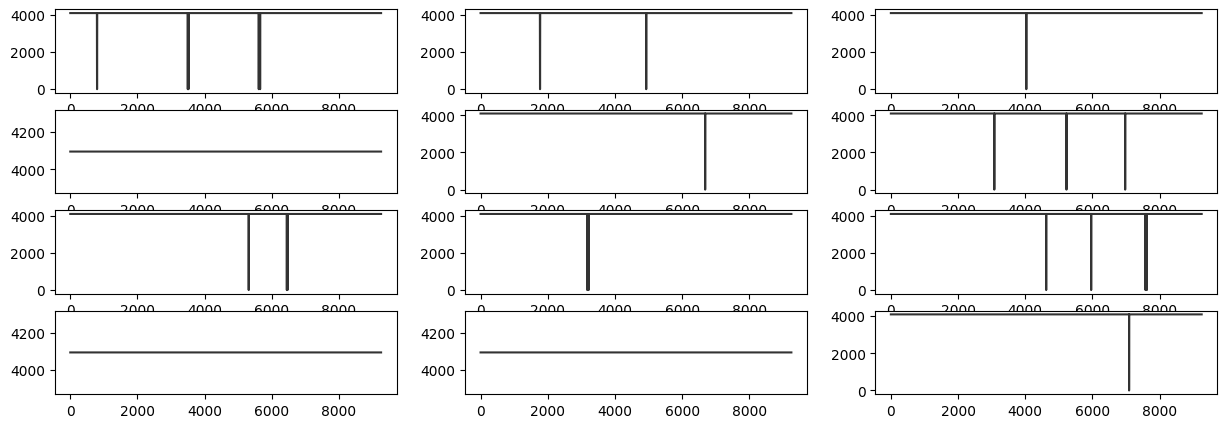

In [39]:
#Normal fans
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_speed[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

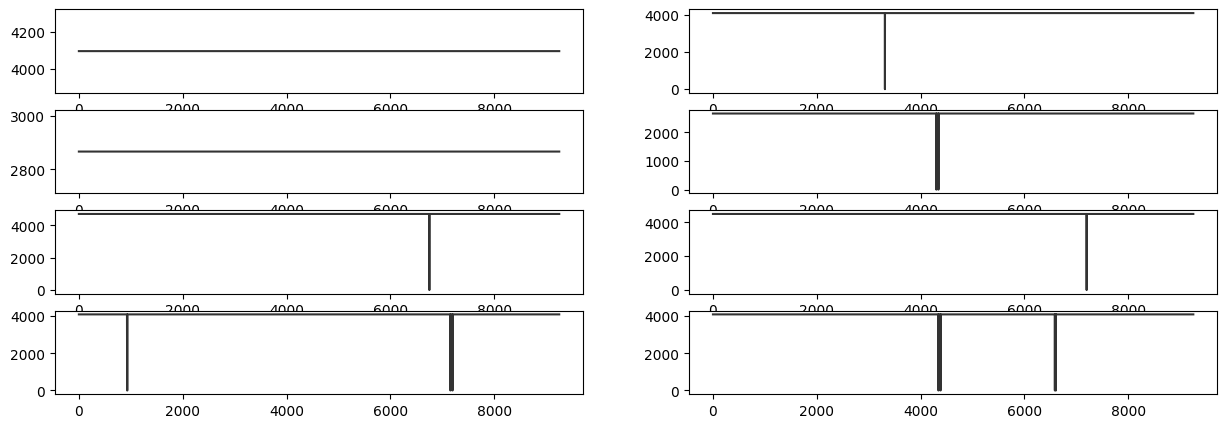

In [40]:
#Some fans with faults
plt.figure(figsize=(15,5))
for yi in range(8):
    plt.subplot(4, 2, yi + 1)
    plt.plot(formatted_speed[31+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

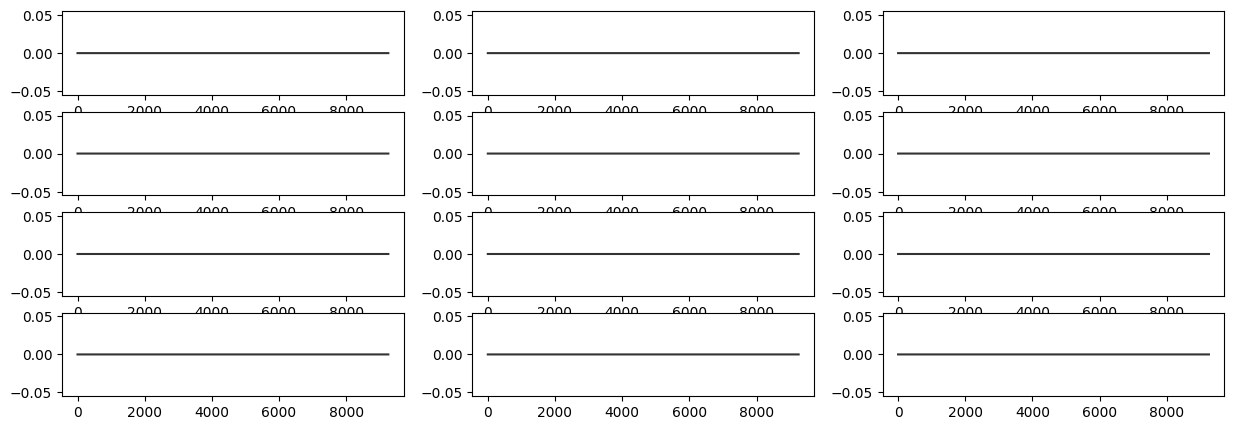

In [41]:
#Normal levels
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_level[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

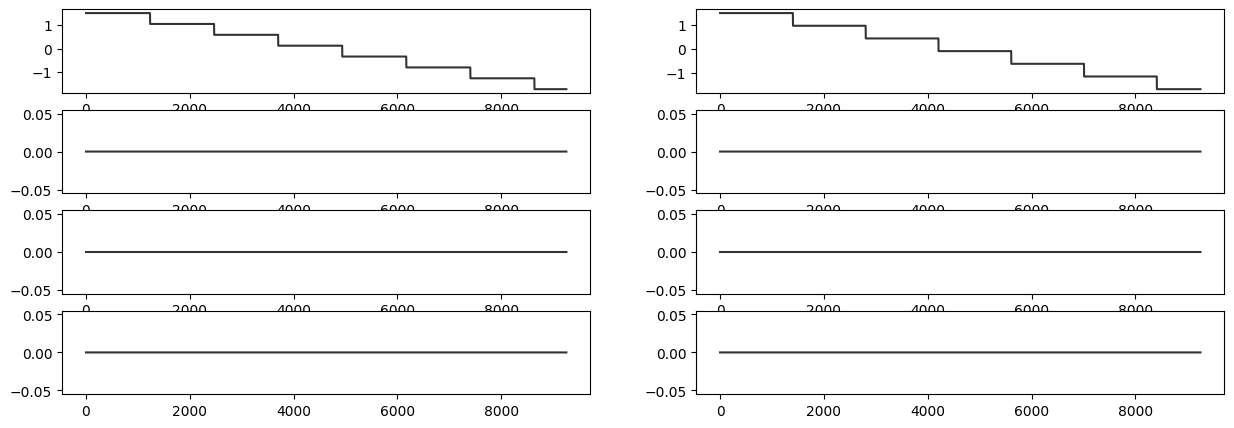

In [42]:
#some faulty coolant levels
plt.figure(figsize=(15,5))
for yi in range(8):
    plt.subplot(4, 2, yi + 1)
    plt.plot(formatted_level[31+yi].ravel(), "k-", alpha=.8)

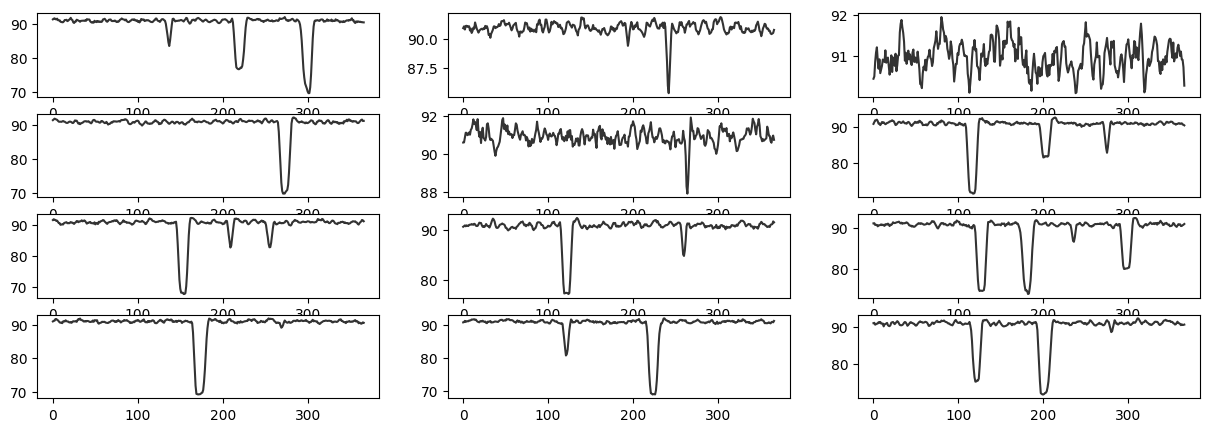

In [43]:
#Normal levels
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_temp[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

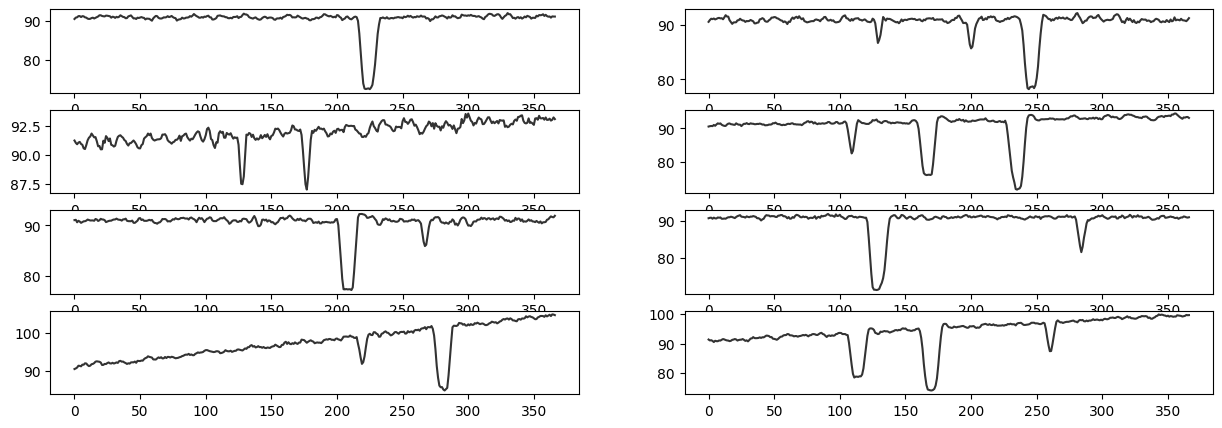

In [44]:
plt.figure(figsize=(15,5))
for yi in range(8):
    plt.subplot(4, 2, yi + 1)
    plt.plot(formatted_temp[31+yi].ravel(), "k-", alpha=.8)

Checking number of Clusters using Dynamic Time Warping
The methods are the Elbow method and Silhoutte Score

In [45]:
Sum_of_squared_distances = []
K = range(2,4)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=1,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_level)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_level)
    sil_score = silhouette_score(formatted_level, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.9916928186490909
[2.568958978327162]
0.9487179487179487
[2.568958978327162, 0.0]


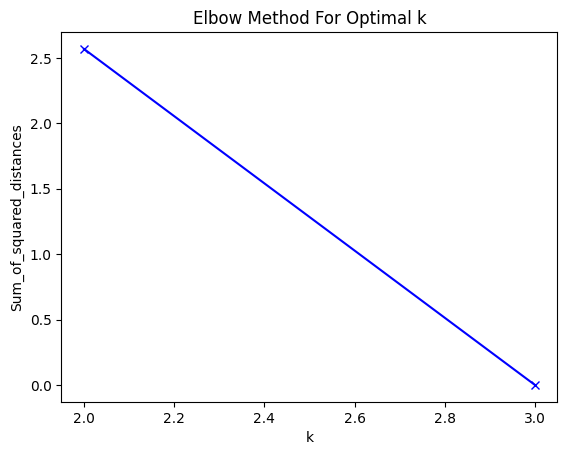

In [46]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

DBA k-means
DBA silhoutte: 0.99


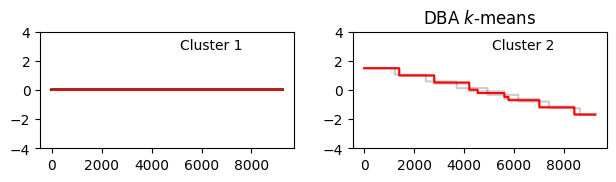

In [47]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_level)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_level, y_pred_dba_km, metric="dtw")))

for yi in range(2):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_level[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()

In [48]:
Sum_of_squared_distances = []
K = range(2,5)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=1,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_speed)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_speed)
    sil_score = silhouette_score(formatted_speed, preds, metric="dtw")
    print(sil_score)
    print(Sum_of_squared_distances)

0.9259049108033113
[141083915.9467893]
0.8815422322521406
[141083915.9467893, 21713714.95726351]
0.471492681469465
[141083915.9467893, 21713714.95726351, 17142173.969500653]


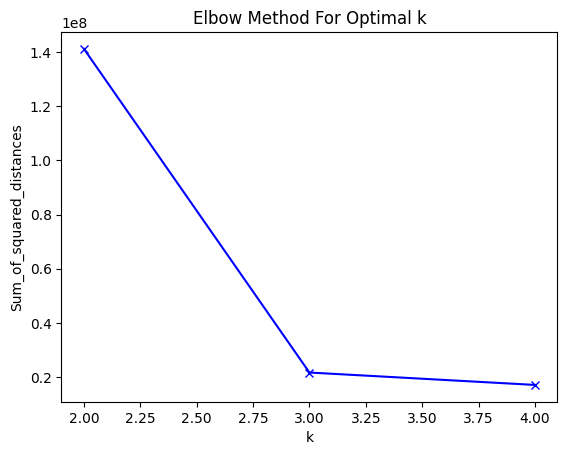

In [49]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

DBA k-means
DBA silhoutte: 0.88


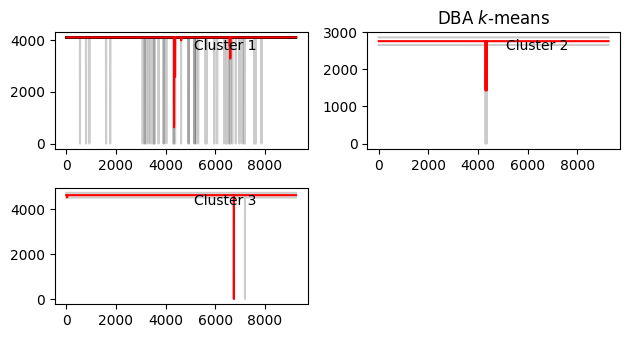

In [50]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_speed)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_speed, y_pred_dba_km, metric="dtw")))

for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_speed[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()

Checking number of Clusters using Euclidean
The methods are the Elbow method and Silhoutte Score

In [51]:
#Coolant Level Using Eucliedean as the metric
Sum_of_squared_distances = []
K = range(2,4)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_level)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_level)
    sil_score = silhouette_score(formatted_level, preds, metric="dtw")
    print(sil_score)
    print(Sum_of_squared_distances)

0.9916928186490909
[5.120182830424956]
0.9487179487179487
[5.120182830424956, 0.0]


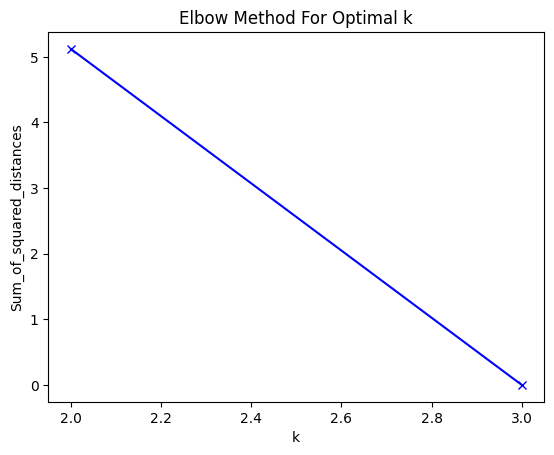

In [52]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

DBA silhoutte: 0.99


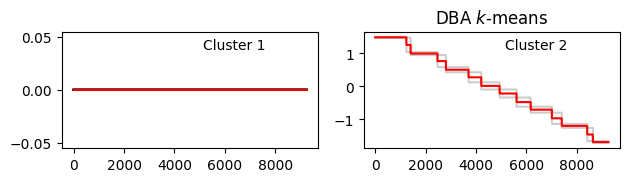

In [53]:
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=1,
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_level)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_level, y_pred_dba_km, metric="dtw")))

for yi in range(2):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_level[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
        


plt.tight_layout()
plt.show()

In [54]:
#Fan speed using Euclidean as the Metric
Sum_of_squared_distances = []
K = range(2,5)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_speed)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_speed)
    sil_score = silhouette_score(formatted_speed, preds, metric="dtw")
    print(sil_score)

0.9259049108033113
0.8815422322521406
0.4350065109315226


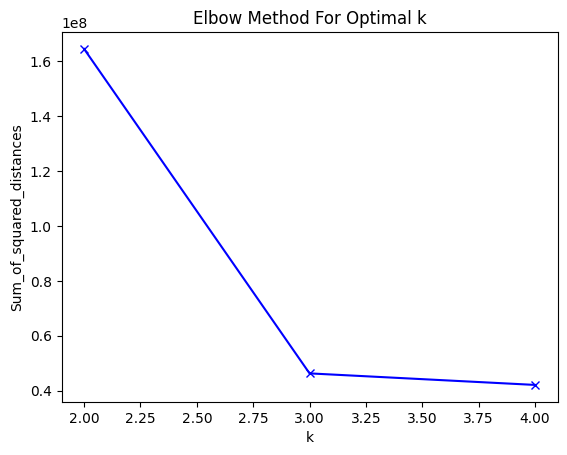

In [55]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

DBA silhoutte: -0.24


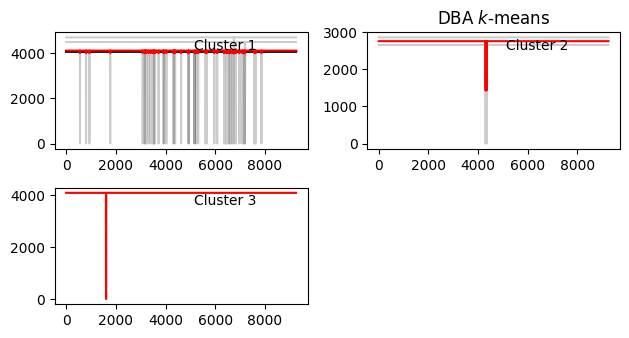

In [56]:
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=1,
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_speed)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_speed, y_pred_dba_km, metric="dtw")))

for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_speed[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
        


plt.tight_layout()
plt.show()

### Coolant Temperature will be tested below only using the DTW method due to the variance and noise

In [57]:
Sum_of_squared_distances = []
K = range(2,5)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=1,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_temp)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_temp)
    sil_score = silhouette_score(formatted_temp, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.6863228395693287
[340.04922126088906]
0.40960439336803184
[340.04922126088906, 235.13707232520736]
0.4195485236528373
[340.04922126088906, 235.13707232520736, 129.83678096016973]


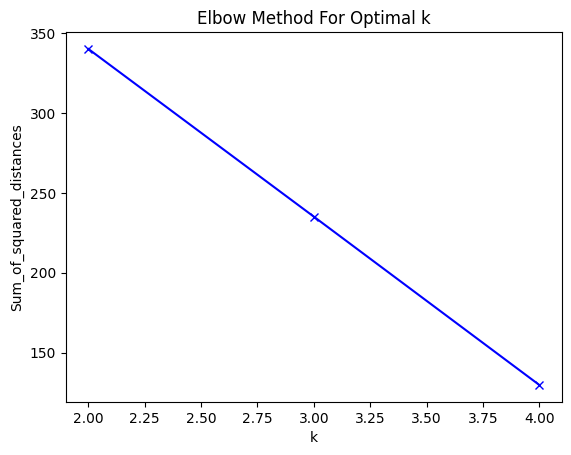

In [58]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

DBA silhoutte: 0.69


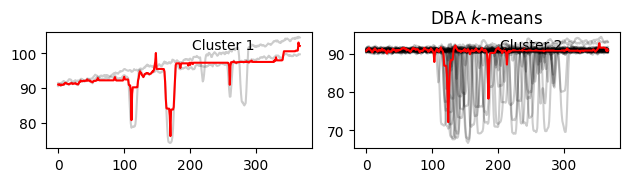

In [60]:
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_temp)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_temp, y_pred_dba_km, metric="dtw")))

for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_temp[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()